[구글 코랩(Colab)에서 실행하기](https://colab.research.google.com/github/lovedlim/tensorflow/blob/main/Part%204/4.5.2_simple_yolo.ipynb)

In [ ]:
# 필요한 패키지를 임포트 함
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# 파라미터 설정

# 이미지 크기
width_size = 256
hight_size = 256
channel_size = 3
img_size = (width_size,hight_size,channel_size)

# 이미지를 나눌 크기
cell_num = 3
# 찾고자 하는 객체 개수
class_num = 3
# 한셀에 그릴 박스 수
anchor_num = 1
label_num = anchor_num * (5 + class_num)
# 학습 수
epoch_num = 20000
# 로스 비중
loss_p_rate = 1.0
loss_cod_rate = 5.0
loss_c_rate = 1.0
loss_p_no_rate = 0.5

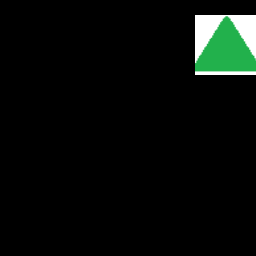

[[[0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [1.         0.67713929 0.52988088 0.25800414 0.24057516 0.
   0.         1.        ]]

 [[0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]]


In [ ]:
# 랜덤하게 도형을 그리고, 실제 정답 값을 생성하는 함수 정의
# 0.png / 1.png / 2.png 파일이 필요함

def make_img_label():
    img = np.zeros((hight_size+400,width_size+400,channel_size))
    label = np.zeros((cell_num,cell_num,label_num))
    num_shape = np.random.randint(1,4)
    i = np.random.choice(range(cell_num),num_shape,replace=False)
    j = np.random.choice(range(cell_num),num_shape,replace=False)
    
    img_0 = cv2.imread('0.png')
    img_1 = cv2.imread('1.png')
    img_2 = cv2.imread('2.png')
    
    for n_h in range(num_shape):
        row = i[n_h]
        col = j[n_h]
        
        shape_type = np.random.randint(0,class_num)
        x_rate = np.random.rand()
        y_rate = np.random.rand()
        w_rate = np.random.rand() * 0.3 +0.1
        h_rate = np.random.rand() * 0.3 +0.1
                
        label[row,col]=[1,x_rate,y_rate,w_rate,h_rate,0,0,0]
        label[row,col,5+shape_type]=1

        x = int(x_rate * width_size/cell_num + col * width_size/cell_num)
        y = int(y_rate * hight_size/cell_num + row * hight_size/cell_num)
        w = int(w_rate * width_size/2) * 2
        h = int(h_rate * hight_size/2) * 2

        if(shape_type==0):
            input_img = cv2.resize(img_0,(w,h))
        if(shape_type==1):
            input_img = cv2.resize(img_1,(w,h))
        if(shape_type==2):
            input_img = cv2.resize(img_2,(w,h))

        img[y-int(h/2)+200 : y+int(h/2)+200, x-int(w/2)+200 : x+int(w/2)+200] =input_img
    img = img[200:200+hight_size,200:200+width_size]        
    
    return img,label

img,label = make_img_label()
cv2_imshow(img)

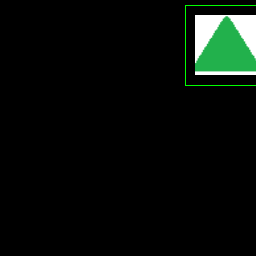

In [ ]:
# 이미지와 정답(혹은 예측값)을 넣으면 박스를 그려주는 함수 정의
# 임계값 th 설정 (객체가 있다는 확률이 th이상일 때만 박스 생성)
def show_box(img,label,th=0.3):
    b_img = np.zeros((hight_size+400,width_size+400,3))
    b_img[200:200+hight_size,200:200+width_size] = img
    for i in range(cell_num):
        for j in range(cell_num):
            if(label[i,j,0] > th):
                x_rate = label[i,j,1]
                y_rate = label[i,j,2]
                w_rate = label[i,j,3]
                h_rate = label[i,j,4]
                shape_type=np.argmax(label[i,j,5:])
                if(shape_type==0):
                    line_color = [0,0,255]
                if(shape_type==1):
                    line_color = [255,0,0]
                if(shape_type==2):
                    line_color = [0,255,0]
                x = int(x_rate * width_size/3 + j * width_size/3)
                y = int(y_rate * hight_size/3 + i * hight_size/3)
                w = int(w_rate * width_size/2) * 2 + 20
                h = int(h_rate * hight_size/2) * 2 + 20

                cv2.rectangle(b_img,(x-int(w/2)+200,y-int(h/2)+200),(x+int(w/2)+200,y+int(h/2)+200),line_color)
                
    b_img = b_img[200:200+hight_size,200:200+width_size]

    return b_img

cv2_imshow(show_box(img,label))

In [ ]:
# VGG16모델을 베이스로 마지막 부분만 수정하는 모델 생성 (전이 학습)
vgg_model = tf.keras.applications.VGG16(include_top=False,input_shape=img_size)
vgg_model.trainable=False

i=tf.keras.Input(shape=img_size)
out=tf.keras.layers.Lambda((lambda x : x/255.))(i)
out = vgg_model(out)
out = tf.keras.layers.Conv2D(256,3,padding='same')(out)
out = tf.keras.layers.Conv2D(128,3,padding='same')(out)
out = tf.keras.layers.Conv2D(64,3,padding='same')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dense(1024,activation='relu')(out)
out = tf.keras.layers.Dense(3*3*8,activation='sigmoid')(out)
out = tf.keras.layers.Reshape((3,3,8))(out)

yolo_model = tf.keras.Model(inputs=[i],outputs=[out])
opt = tf.keras.optimizers.Adam(0.00001)

# 모델 요약
yolo_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         1179904   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         295040    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          73792     
______________________________________________________________

In [ ]:
# 학습과정을 동영상으로 기록
fcc=cv2.VideoWriter_fourcc(*'DIVX')
out=cv2.VideoWriter('hjk_yolo.avi',fcc,1.0,(width_size,hight_size))


for e in range(epoch_num):
    img,label = make_img_label()
    img = np.reshape(img,(1,hight_size,width_size,3))
    label = np.reshape(label,(1,3,3,8))
    loss_p_list=[]
    loss_cod_list = []
    loss_c_list = []
    loss_p_no_list = []
    with tf.GradientTape() as tape:
        pred = yolo_model(img)
        # 이미지를 구분한 셀을 탐험
        for i in range(3):
            for j in range(3):
                # 해당 셀에 객체가 있을 경우는 확률, 박스 크기, 클래스까지 모두 Loss로 계산
                if(label[0,i,j,0]==1):
                    loss_p_list.append(tf.square(label[0,i,j,0]-pred[0,i,j,0]))
                    loss_cod_list.append(tf.square(label[0,i,j,1]-pred[0,i,j,1]))
                    loss_cod_list.append(tf.square(label[0,i,j,2]-pred[0,i,j,2]))
                    loss_cod_list.append(tf.square(label[0,i,j,3]-pred[0,i,j,3]))
                    loss_cod_list.append(tf.square(label[0,i,j,4]-pred[0,i,j,4]))
                    loss_c_list.append(tf.square(label[0,i,j,5]-pred[0,i,j,5]))
                    loss_c_list.append(tf.square(label[0,i,j,6]-pred[0,i,j,6]))
                    loss_c_list.append(tf.square(label[0,i,j,7]-pred[0,i,j,7]))
                # 해당 셀에 객체가 없을 경우 객체가 없을 확률만 Loss로 계산
                else:
                    loss_p_no_list.append(tf.square(label[0,i,j,0]-pred[0,i,j,0]))
        loss_p=tf.reduce_mean(loss_p_list)
        loss_cod =tf.reduce_mean(loss_cod_list)
        loss_c = tf.reduce_mean(loss_c_list)
        loss_p_no = tf.reduce_mean(loss_p_no_list)
        # 각 Loss를 비중을 곱해 더해 최종 Loss를 계산
        loss = loss_p_rate * loss_p + loss_cod_rate * loss_cod + loss_c_rate * loss_c + loss_p_no_rate * loss_p_no
    # Loss에 대한 Grad를 구하고, 각 파라미터를 업데이트
    vars = yolo_model.trainable_variables
    grad = tape.gradient(loss, vars)
    opt.apply_gradients(zip(grad, vars))
    # 100번 마다 동영상에 이미지를 기록한다
    if(e%100==0):
        img = np.reshape(img,(256,256,3))
        label = pred.numpy()
        label = np.reshape(label,(3,3,8))
        sample_img = np.uint8(show_box(img,label))
        out.write(sample_img)
    print(e,"완료",loss.numpy())    
out.release()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
15000 완료 0.0192022
15001 완료 0.017613187
15002 완료 0.14400822
15003 완료 0.011352711
15004 완료 0.024062848
15005 완료 0.11858782
15006 완료 0.029009005
15007 완료 0.022141369
15008 완료 0.017550258
15009 완료 0.01595803
15010 완료 0.108549714
15011 완료 0.050535362
15012 완료 0.025654284
15013 완료 0.09450328
15014 완료 0.02936035
15015 완료 0.040152736
15016 완료 0.09072897
15017 완료 0.08764083
15018 완료 0.026179077
15019 완료 0.03231062
15020 완료 0.03653
15021 완료 0.16250125
15022 완료 0.03321566
15023 완료 0.061447706
15024 완료 0.037769742
15025 완료 0.02250934
15026 완료 0.022256989
15027 완료 0.05120215
15028 완료 0.054337434
15029 완료 0.09900381
15030 완료 0.023818698
15031 완료 0.10086973
15032 완료 0.019039772
15033 완료 0.039357703
15034 완료 0.039797634
15035 완료 0.106904075
15036 완료 0.034347776
15037 완료 0.022826916
15038 완료 0.0143101495
15039 완료 0.05012763
15040 완료 0.030279834
15041 완료 0.017644133
15042 완료 0.040509023
15043 완료 0.01047481
15044 완료 0.050212264
15045 완료 0.021444187
15046 완료 0.04936674